# 機械学習をPythonで実践する-15　　～ EDA ～

In [29]:
%load_ext autoreload
%autoreload 2
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
# from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder
# # import statsmodels.api as sma
# from sklearn.model_selection import train_test_split ,cross_val_score, KFold, RepeatedKFold,StratifiedKFold
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, confusion_matrix,ConfusionMatrixDisplay, \
# accuracy_score, precision_score, recall_score,precision_recall_curve,f1_score,roc_curve,auc,get_scorer_names,roc_auc_score
# from sklearn import tree
# from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier, GradientBoostingRegressor, GradientBoostingClassifier


%matplotlib inline
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. データロード

In [12]:
# 元のCSVでは欠損値の表現がN/Aとなっているので、null_values='N/A'を指定しないと読み込みエラーになる。
df = pl.read_csv('/work/TIL/Python/sample_data/ML_sample/vgsales.csv', sep=',', null_values='N/A')

In [11]:
df.head()

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
i64,str,str,i64,str,str,f64,f64,f64,f64,f64
1,"""Wii Sports""","""Wii""",2006,"""Sports""","""Nintendo""",41.49,29.02,3.77,8.46,82.74
2,"""Super Mario Br...","""NES""",1985,"""Platform""","""Nintendo""",29.08,3.58,6.81,0.77,40.24
3,"""Mario Kart Wii...","""Wii""",2008,"""Racing""","""Nintendo""",15.85,12.88,3.79,3.31,35.82
4,"""Wii Sports Res...","""Wii""",2009,"""Sports""","""Nintendo""",15.75,11.01,3.28,2.96,33.0
5,"""Pokemon Red/Po...","""GB""",1996,"""Role-Playing""","""Nintendo""",11.27,8.89,10.22,1.0,31.37


In [13]:
df.columns

['Rank',
 'Name',
 'Platform',
 'Year',
 'Genre',
 'Publisher',
 'NA_Sales',
 'EU_Sales',
 'JP_Sales',
 'Other_Sales',
 'Global_Sales']

各カラムの意味はすぐ見れるところにメモしておくとよい。

In [16]:
# 欠損値の数を確認
df.null_count()

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,271,0,58,0,0,0,0,0


## 2. 量的変数、質的変数の確認

In [21]:
# 下記のように書くと、df.dtypes（リスト）の順序を保ったままユニークな値を取り出せる。
list(dict.fromkeys(df.dtypes))

[Int64, Utf8, Float64]

In [25]:
# 量的変数と質的変数のカラム名をそれぞれ取得
num_feat = df.select([pl.col(pl.Int64), pl.col(pl.Float64)]).columns
cat_feat = df.select(pl.col(pl.Utf8)).columns

## 3.  各カラムの統計量(min, max, mean, etc)

In [27]:
df[num_feat].describe()

describe,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
str,f64,f64,f64,f64,f64,f64,f64
"""count""",16598.0,16598.0,16598.0,16598.0,16598.0,16598.0,16598.0
"""null_count""",0.0,271.0,0.0,0.0,0.0,0.0,0.0
"""mean""",8300.605254,2006.406443,0.264667,0.146652,0.077782,0.048063,0.537441
"""std""",4791.853933,5.828981,0.816683,0.505351,0.309291,0.188588,1.555028
"""min""",1.0,1980.0,0.0,0.0,0.0,0.0,0.01
"""max""",16600.0,2020.0,41.49,29.02,10.22,10.57,82.74
"""median""",8300.5,2007.0,0.08,0.02,0.0,0.01,0.17


各地域のSalesの最小値は０だが、Global_Salesは0.01なので、  
完全に全世界売上０のデータは含まれていないと推察される。

In [118]:
df[num_feat].quantile(0.75)

Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
f64,f64,f64,f64,f64,f64,f64
12450.0,2010.0,0.24,0.11,0.04,0.04,0.47


<AxesSubplot:xlabel='Publisher'>

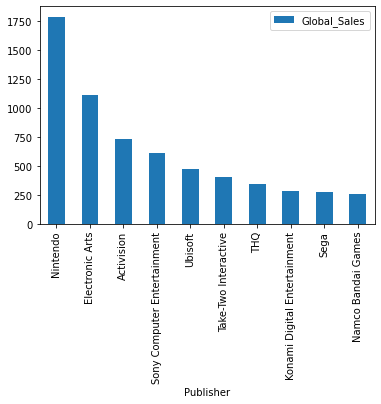

In [138]:
# 販売元でgroupby
df.groupby('Publisher').sum().sort('Global_Sales', reverse=True).to_pandas()[:10].plot.bar(x='Publisher',y='Global_Sales')

任天堂の売り上げが圧倒的。

In [144]:
df['Year'].value_counts().sort('Year')

Year,counts
i64,u32
null,271
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16


恐らく2016年の途中までのデータだと思われる。  
2017,2020年のデータは後から足された感じ。  
実際の業務ではこれらのデータの年が間違っていないかまで調べる。

In [151]:
df.sort('Year', reverse=True)[:10]

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
i64,str,str,i64,str,str,f64,f64,f64,f64,f64
5959,"""Imagine: Makeu...","""DS""",2020,"""Simulation""","""Ubisoft""",0.27,0.0,0.0,0.02,0.29
14393,"""Phantasy Star ...","""PS4""",2017,"""Role-Playing""","""Sega""",0.0,0.0,0.03,0.0,0.03
16244,"""Phantasy Star ...","""PSV""",2017,"""Role-Playing""","""Sega""",0.0,0.0,0.01,0.0,0.01
16441,"""Brothers Confl...","""PSV""",2017,"""Action""","""Idea Factory""",0.0,0.0,0.01,0.0,0.01
222,"""FIFA 17""","""PS4""",2016,"""Sports""","""Electronic Art...",0.28,3.75,0.06,0.69,4.77
272,"""Uncharted 4: A...","""PS4""",2016,"""Shooter""","""Sony Computer ...",1.3,2.07,0.18,0.65,4.2
352,"""Tom Clancy's T...","""PS4""",2016,"""Shooter""","""Ubisoft""",1.28,1.61,0.15,0.57,3.61
772,"""Far Cry: Prima...","""PS4""",2016,"""Action""","""Ubisoft""",0.59,1.16,0.06,0.33,2.13
847,"""Tom Clancy's T...","""XOne""",2016,"""Shooter""","""Ubisoft""",1.2,0.62,0.0,0.18,2.01


## 4.  各カラム同士の散布図とそれぞれのカラムのヒストグラムを確認

In [28]:
len(num_feat)

7

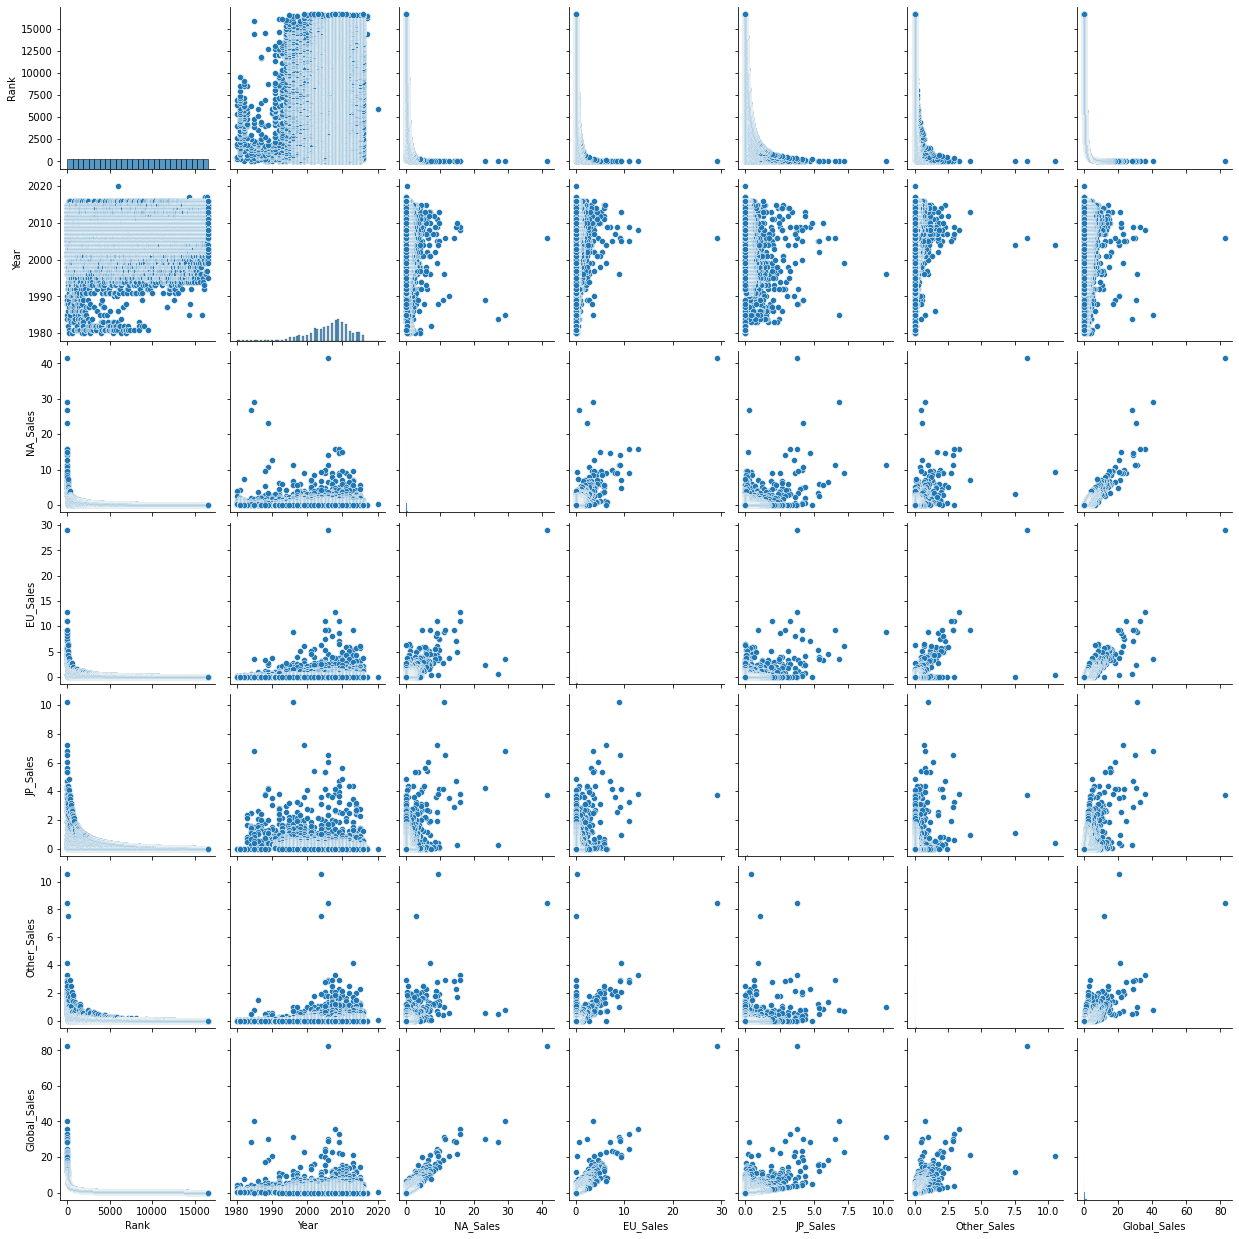

In [40]:
sns.pairplot(df.to_pandas())

sns.pairplotで出力される対角線部分のグラフは各カラムのヒストグラムになっている。  
XXX_Salesはかなり外れ値の影響があり、左に偏った散布図になっているので、logをとった方が見やすい。

sns.pairplotよりも柔軟にデータを見たいときは下記のようなコードで見るのもよいかも。  
時間も大して変わらなそう。

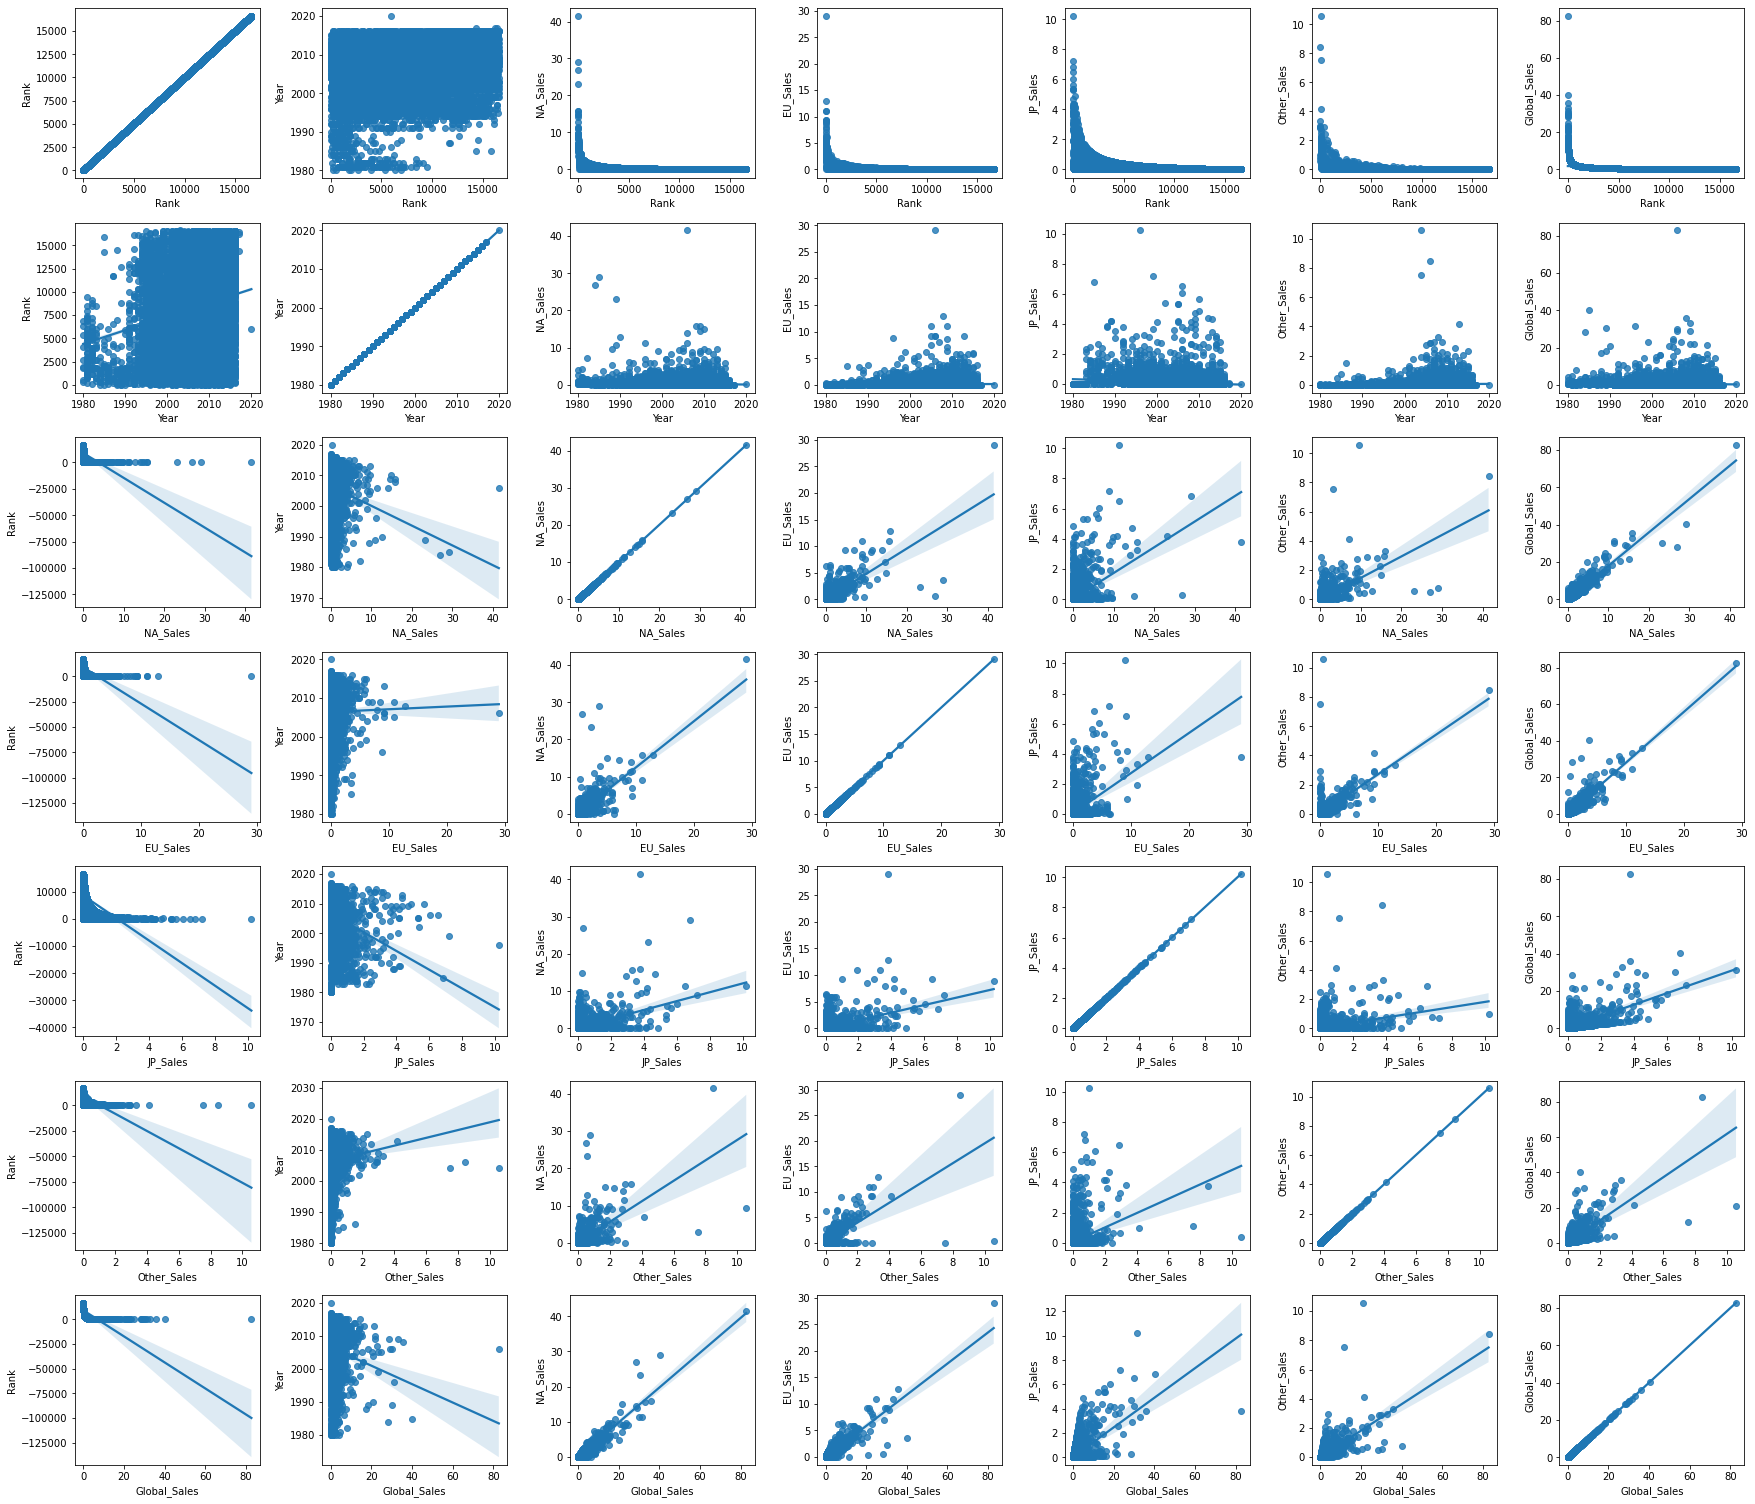

In [80]:
rows = 7
cols = 7
fig, axes = plt.subplots(rows, cols, figsize=(cols*3.5,rows*3))

# 行番号と列番号、量的変数の全組み合わせを取得する。
# これにより描画位置を指定し、各カラム同士の関係を可視化できる。
li_row_col = list(itertools.product(range(0, rows),range(0, cols)))
li_num_feats = list(itertools.product(num_feat, num_feat))
corr_coefs = {}

# 量的変数名のリストと描画位置のリストをzipでまとめる。
for feats, row_col in zip(li_num_feats, li_row_col):
    sns.regplot(x=df[feats[0]], y=df[feats[1]], ax=axes[row_col])
    # stats.pearsonrでピアソンの相関係数を求めるにはNaNを置き換えておく必要あり。
    # r, p = stats.pearsonr(x=df_train[feat], y=df_train[target])
    # targetとデータ型を合わせる必要あり。
    # corr_coef = df_train.select( pl.pearson_corr(target, pl.col(feat).cast(pl.Float64)) ).item()
    # corr_coefs[feat] = corr_coef
    # axes[row_col].set_title(f'corr_coef={corr_coef:.5f}', fontsize=11)
    axes[row_col].set_xlabel(feats[0])
    axes[row_col].set_ylabel(feats[1])
    
    
plt.tight_layout()

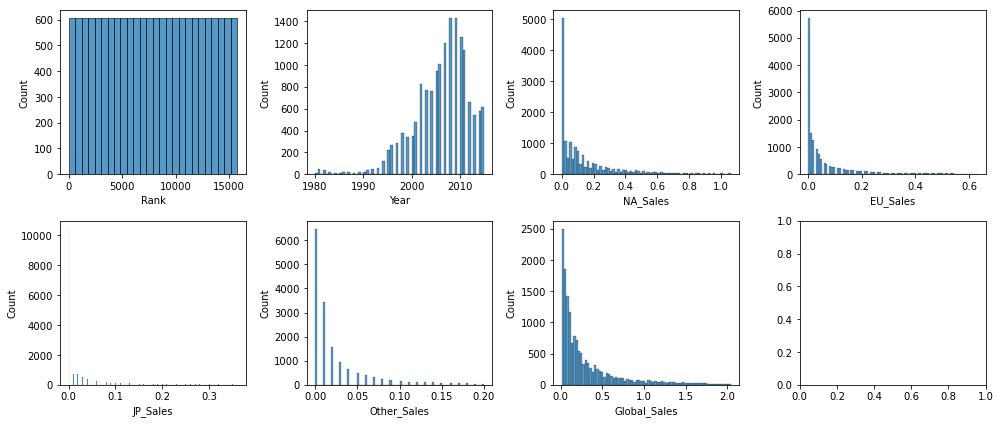

In [97]:
rows = 2
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(cols*3.5,rows*3))

# 行番号と列番号、量的変数の全組み合わせを取得する。
# これにより描画位置を指定し、各カラム同士の関係を可視化できる。
li_row_col = list(itertools.product(range(0, rows),range(0, cols)))

# 量的変数名のリストと描画位置のリストをzipでまとめる。
for feat, row_col in zip(num_feat, li_row_col):
    # ヒストグラムの横軸に使用するデータの範囲を99%tileまでとする。（外れ値を外さないと描画に時間がかかる）
    qtile = df.get_column(feat).quantile(0.95)
    x = df.filter(pl.col(feat).is_between(0, qtile)).get_column(feat)

    sns.histplot(x=x, ax=axes[row_col])
    axes[row_col].set_xlabel(feat)

plt.tight_layout()

Salesは非常にゆがんだ分布になっている。

## 5. 各カテゴリのレコード数を確認

In [88]:
df[cat_feat].head()

Name,Platform,Genre,Publisher
str,str,str,str
"""Wii Sports""","""Wii""","""Sports""","""Nintendo"""
"""Super Mario Br...","""NES""","""Platform""","""Nintendo"""
"""Mario Kart Wii...","""Wii""","""Racing""","""Nintendo"""
"""Wii Sports Res...","""Wii""","""Sports""","""Nintendo"""
"""Pokemon Red/Po...","""GB""","""Role-Playing""","""Nintendo"""


In [93]:
df.groupby('Platform').count().sort('count', reverse=True)

Platform,count
str,u32
"""DS""",2163
"""PS2""",2161
"""PS3""",1329
"""Wii""",1325
"""X360""",1265
"""PSP""",1213
"""PS""",1196
"""PC""",960
"""XB""",824


Groupbyではなくvalue_countsでもOK.こっちの方が早いかも。

In [156]:
df['Genre'].value_counts().sort('counts', reverse=True)

Genre,counts
str,u32
"""Action""",3316
"""Sports""",2346
"""Misc""",1739
"""Role-Playing""",1488
"""Shooter""",1310
"""Adventure""",1286
"""Racing""",1249
"""Platform""",886
"""Simulation""",867


各クラス名に重複（意味合いとしても）、誤字・脱字がないか調べる。

In [157]:
df.groupby('Publisher').count().sort('count', reverse=True)

Publisher,count
str,u32
"""Electronic Art...",1351
"""Activision""",975
"""Namco Bandai G...",932
"""Ubisoft""",921
"""Konami Digital...",832
"""THQ""",715
"""Nintendo""",703
"""Sony Computer ...",683
"""Sega""",639


## 6. 外れ値の確認

何を外れ値とするかは分析対象・目的によって異なるので、適宜考えること。  
（設定例：1%ile～99%ile範囲外のデータ、売上1M以下のデータなど）  
以下では大多数の集団から孤立しているデータを外れ値とする。  

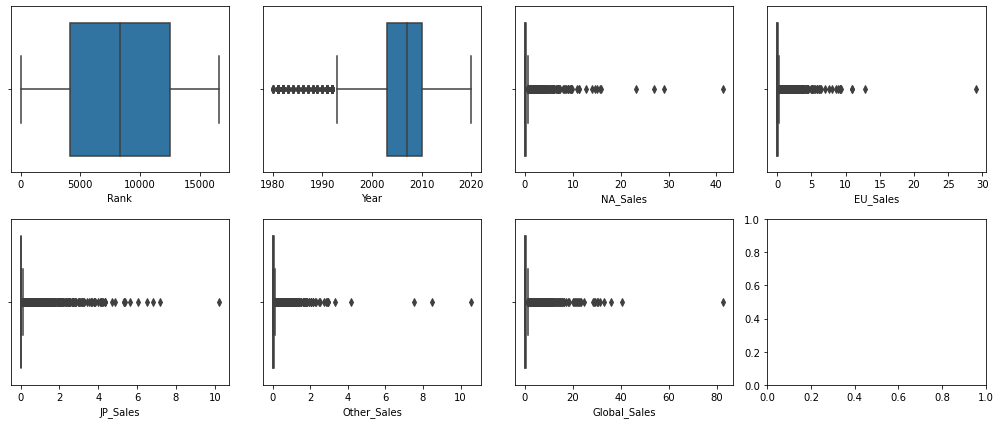

In [100]:
rows = 2
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(cols*3.5,rows*3))

# 行番号と列番号、量的変数の全組み合わせを取得する。
# これにより描画位置を指定し、各カラム同士の関係を可視化できる。
li_row_col = list(itertools.product(range(0, rows),range(0, cols)))

# 量的変数名のリストと描画位置のリストをzipでまとめる。
for feat, row_col in zip(num_feat, li_row_col):
    sns.boxplot(x=feat, data=df.to_pandas(), ax=axes[row_col])
    axes[row_col].set_xlabel(feat)

plt.tight_layout()

外れ値が大きすぎて、箱が表示されない場合があるが、  
大まかな外れ値の値は分かる。  
Salesの０近傍と突出して高い値は外れ値とみなせそう。

## 7. カラム間の相関

In [115]:
# 量的変数の相関係数算出。nullを落としておく必要あり。pandas DFに変換しておいた方がヒートマップは見やすい。
df_corr = df[num_feat].drop_nulls().to_pandas().corr()
df_corr

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Rank,1.000000,0.178814,-0.400328,-0.379024,-0.269138,-0.332521,-0.426880
Year,0.178814,1.000000,-0.091402,0.006014,-0.169316,0.041058,-0.074735
NA_Sales,-0.400328,-0.091402,1.000000,0.768936,0.451285,0.634508,0.941268
EU_Sales,-0.379024,0.006014,0.768936,1.000000,0.436414,0.726266,0.903271
JP_Sales,-0.269138,-0.169316,0.451285,0.436414,1.000000,0.290653,0.612794
Other_Sales,-0.332521,0.041058,0.634508,0.726266,0.290653,1.000000,0.747974
Global_Sales,-0.426880,-0.074735,0.941268,0.903271,0.612794,0.747974,1.000000


<AxesSubplot:>

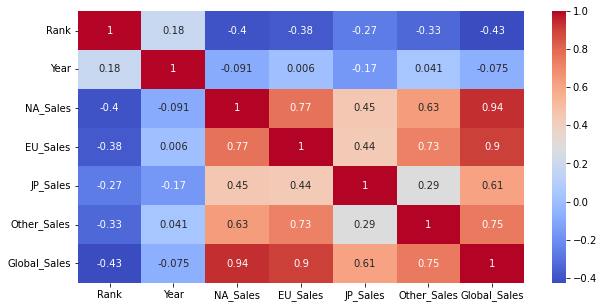

In [114]:
## heatmapを作成.数値を入れたいときはannot=Trueとする
fig, ax = plt.subplots(figsize=(10, 5)) 
sns.heatmap(df_corr, ax=ax,annot=True, cmap='coolwarm')

Sales間の相関が比較的高く、特にNA,EUの相関が高い。  
これは市場規模が大きいためと思われる。  
相関が高すぎるため、線形モデルで学習する際の多重共線性（マルチコ）を疑う必要がある。  
Global_Salesはその他のSalesの純粋な和であれば多重共線性が高く、特徴量には適さない。  
また、その他の和 < Global_Sales ならデータにはないSalesがあることになり、データのクオリティが低い可能性がある。  

In [158]:
df.head(1)

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
i64,str,str,i64,str,str,f64,f64,f64,f64,f64
1,"""Wii Sports""","""Wii""",2006,"""Sports""","""Nintendo""",41.49,29.02,3.77,8.46,82.74


In [164]:
# Global_Salesとその他の和の差をチェックする
df.with_columns(
    (pl.col('NA_Sales') + pl.col('EU_Sales') + pl.col('JP_Sales') + pl.col('Other_Sales'))
    .alias('NA_EU_JP_Other')
).with_columns(
    (pl.col('Global_Sales') - pl.col('NA_EU_JP_Other')).abs().alias('diff_Sales')
).sort('diff_Sales', reverse=True).head(10)

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,NA_EU_JP_Other,diff_Sales
i64,str,str,i64,str,str,f64,f64,f64,f64,f64,f64,f64
106,"""Tekken 3""","""PS""",1998,"""Fighting""","""Sony Computer ...",3.27,2.22,1.4,0.29,7.16,7.18,0.02
1383,"""Need For Speed...","""PS2""",2008,"""Racing""","""Electronic Art...",0.38,0.08,0.03,0.93,1.4,1.42,0.02
1413,"""Need for Speed...","""X360""",2011,"""Action""","""Electronic Art...",0.63,0.58,0.0,0.15,1.38,1.36,0.02
1550,"""Kid Icarus: Up...","""3DS""",2012,"""Action""","""Nintendo""",0.48,0.35,0.36,0.07,1.28,1.26,0.02
3234,"""Wet""","""PS3""",2009,"""Shooter""","""Bethesda Softw...",0.22,0.27,0.01,0.11,0.63,0.61,0.02
4593,"""Yu-Gi-Oh! GX: ...","""PSP""",2007,"""Strategy""","""Konami Digital...",0.03,0.2,0.1,0.11,0.42,0.44,0.02
5828,"""One Piece: Unl...","""PS3""",2014,"""Action""","""Namco Bandai G...",0.09,0.12,0.06,0.05,0.3,0.32,0.02
7988,"""Call of Juarez...","""X360""",2007,"""Shooter""","""Ubisoft""",0.14,0.02,0.0,0.01,0.19,0.17,0.02
2076,"""Rocksmith 2014...","""PS3""",2013,"""Misc""","""Ubisoft""",0.51,0.27,0.05,0.15,1.0,0.98,0.02


差が最も大きいものでも0.02程度なので、大きな乖離はないと考える。  
0.02程度の差の原因は恐らくGlobal_Salesとその他Salesは別々にとった値であり、  
データに入力した際の丸め方に起因するものだと思われる。